In [48]:
import pandas as pd

from oversampling_multiclass import (
    split_dataset,
    apply_smote_multiclass,
    train_random_forest_multiclass,
    train_svm_multiclass,
    train_lightgbm_multiclass,
    rf_plot_confusion_matrices,
    svm_plot_confusion_matrices,
    lightgbm_plot_confusion_matrices
)
from oversampling_multiclass_extra import train_random_forest_multiclass_extra

# CLASSIFICAZIONE MULTICLASSE

In [2]:
csv_file_path = 'C:/Users/frees/Documents/GitHub/UnderwaterClassification/features_extraction/audio_features.csv'

In [3]:
df = pd.read_csv(csv_file_path)

In [4]:
print("Distribuzione delle subclass prima dello split:")
print(df['Subclass'].value_counts())

Distribuzione delle subclass prima dello split:
Subclass
Passengership                 11728
Tanker                        11221
Tug                           10162
Cargo                          9671
Humpback Whale                 1523
                              ...  
Unknown fish knoks                2
Harbor porpoise                   1
Australian Snubfin Dolphin        1
Pygmy Right Whale                 1
True_s beaked whale               1
Name: count, Length: 112, dtype: int64


In [5]:
df

,File Name,Class,Subclass,Spectral Centroid Mean,Spectral Bandwidth RMS,Standard Deviation,Skewness,Kurtosis,Shannon Entropy,Renyi Entropy,Rate of Attack,Rate of Decay,Threshold Crossings,Silence Ratio,Mean,Max Over Mean,Min Over Mean,Energy Measurements
0,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg1.wav,Non-Target,Ambient Noise,2585.774150,3545.441382,0.226857,0.290663,0.892096,4.972139,-5.535674,376.987654,0.003933,4596,0.611758,-0.034153,-21.482748,23.621908,0.052631
1,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg2.wav,Non-Target,Ambient Noise,3004.490961,3774.635411,0.108625,-0.005662,-0.569438,5.162510,-6.898534,388.414286,0.003898,4892,0.634714,-0.032923,-9.492707,10.171222,0.012883
2,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg3.wav,Non-Target,Ambient Noise,2374.518939,3489.082003,0.247894,-0.276421,0.685544,4.945729,-5.216699,354.935065,0.003911,2814,0.576922,-0.030692,-25.133602,32.582104,0.062393
3,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg4.wav,Non-Target,Ambient Noise,2821.144296,3698.989681,0.156887,0.579543,1.394184,4.977810,-6.245069,351.652174,0.003900,3842,0.676630,-0.033124,-17.890182,14.250049,0.025711
4,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg5.wav,Non-Target,Ambient Noise,2649.515257,3629.187032,0.182234,-0.088010,-0.083039,5.108433,-5.868417,360.301370,0.003938,4086,0.587979,-0.031081,-16.133920,20.697605,0.034175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50988,ship_small_seg5.wav,Target,Vessel,456.747011,797.837269,0.194804,0.013841,0.040806,4.912163,-5.505589,374.087500,0.004186,3257,0.502427,0.010898,67.170630,-71.718500,0.038067
50989,ship_small_seg6.wav,Target,Vessel,452.009912,804.062723,0.187102,0.015867,0.072808,4.923598,-5.597314,374.125000,0.004034,3284,0.499966,0.010380,68.853870,-69.641780,0.035115
50990,ship_small_seg7.wav,Target,Vessel,446.388360,808.959976,0.179071,0.000758,0.094906,4.904681,-5.670921,374.100000,0.003832,3247,0.500477,0.011149,60.261180,-65.437140,0.032191
50991,ship_small_seg8.wav,Target,Vessel,451.316540,794.817133,0.188441,-0.002943,0.136695,4.846811,-5.513616,374.087500,0.004043,3283,0.495841,0.010464,76.876610,-72.440750,0.035620


### Filtro dataframe

In [6]:
df['File Name'] = df['File Name'].str[:-4]
df = df[df['Class'] == 'Target'].copy()
# Aggiungi una colonna "Parent" che contiene il prefisso dei file per garantire la coesione dei segmenti
df['Parent'] = df['File Name'].str.extract(r'^(.*?)(?=_seg)')

# Filtra le subclass con almeno 10 parent distinti
parent_counts = df.groupby('Subclass')['Parent'].nunique()
subclasses_to_keep = parent_counts[parent_counts >= 10].index
df = df[df['Subclass'].isin(subclasses_to_keep)].copy()

print(f"Dimensione totale dopo il filtraggio: {df.shape[0]} campioni")

Dimensione totale dopo il filtraggio: 43089 campioni


## SPLIT

In [7]:
X_train_imputed, X_val_imputed, X_test_imputed, y_train_encoded, y_val_encoded, y_test_encoded, subclass_encoder = split_dataset(df)


Train size: 33872 (78.61%)
Val size:   4403 (10.22%)
Test size:  4814 (11.17%)

Distribuzione di 'Subclass' nel train:
Subclass
Passengership    8830
Tanker           8744
Tug              8213
Cargo            7802
Vessel            283
Name: count, dtype: int64

Distribuzione di 'Subclass' nel val:
Subclass
Passengership    1291
Tanker           1276
Tug               956
Cargo             862
Vessel             18
Name: count, dtype: int64

Distribuzione di 'Subclass' nel test:
Subclass
Passengership    1607
Tanker           1201
Cargo            1007
Tug               993
Vessel              6
Name: count, dtype: int64


In [8]:
X_train_imputed[['File Name', 'Parent', 'Subclass']].groupby(['Parent', 'File Name']).describe()

Subclass  \
                                                                                   count   
Parent                               File Name                                             
1cc5583b-fe72-4cb2-b64c-563bd87ad91b 1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg1         1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg10        1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg11        1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg12        1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg13        1   
...                                                                                  ...   
ship_small                           ship_small_seg5                                   1   
                                     ship_small_seg6                                   1   
                                     ship_small_seg7                                   1   
                                     ship_small_seg8                                   1   
                                     ship_small_seg9                                   1   

                                                                                        \
                                                                                unique   
Parent                               File Name                                           
1cc5583b-fe72-4cb2-b64c-563bd87ad91b 1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg1       1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg10      1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg11      1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg12      1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg13      1   
...                                                                                ...   
ship_small                           ship_small_seg5                                 1   
                                     ship_small_seg6                                 1   
                                     ship_small_seg7                                 1   
                                     ship_small_seg8                                 1   
                                     ship_small_seg9                                 1   

                                                                                                \
                                                                                           top   
Parent                               File Name                                                   
1cc5583b-fe72-4cb2-b64c-563bd87ad91b 1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg1   Passengership   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg10  Passengership   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg11  Passengership   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg12  Passengership   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg13  Passengership   
...                                                                                        ...   
ship_small                           ship_small_seg5                                    Vessel   
                                     ship_small_seg6                                    Vessel   
                                     ship_small_seg7                                    Vessel   
                                     ship_small_seg8                                    Vessel   
                                     ship_small_seg9                                    Vessel   

                                                                                      
                                                                      

In [9]:
X_test_imputed[['File Name', 'Parent','Subclass']].groupby(['Parent', 'File Name']).describe()

Subclass  \
                                                                                                    count   
Parent                                        File Name                                                     
20160516a-9_9                                 20160516a-9_9_seg1                                        1   
                                              20160516a-9_9_seg2                                        1   
                                              20160516a-9_9_seg3                                        1   
20160616b-21_200904                           20160616b-21_200904_seg1                                  1   
                                              20160616b-21_200904_seg10                                 1   
...                                                                                                   ...   
SanctSound_GR01_01_vessel_20181217T204109Z    SanctSound_GR01_01_vessel_20181217T204109Z_seg2           1   
SanctSound_HI04_02_smallboat_20191211T175807Z SanctSound_HI04_02_smallboat_20191211T175807Z_seg1        1   
                                              SanctSound_HI04_02_smallboat_20191211T175807Z_seg2        1   
SanctSound_SB03_09_vessel_20200415T161235Z    SanctSound_SB03_09_vessel_20200415T161235Z_seg1           1   
                                              SanctSound_SB03_09_vessel_20200415T161235Z_seg2           1   

                                                                                                         \
                                                                                                 unique   
Parent                                        File Name                                                   
20160516a-9_9                                 20160516a-9_9_seg1                                      1   
                                              20160516a-9_9_seg2                                      1   
                                              20160516a-9_9_seg3                                      1   
20160616b-21_200904                           20160616b-21_200904_seg1                                1   
                                              20160616b-21_200904_seg10                               1   
...                                                                                                 ...   
SanctSound_GR01_01_vessel_20181217T204109Z    SanctSound_GR01_01_vessel_20181217T204109Z_seg2         1   
SanctSound_HI04_02_smallboat_20191211T175807Z SanctSound_HI04_02_smallboat_20191211T175807Z_seg1      1   
                                              SanctSound_HI04_02_smallboat_20191211T175807Z_seg2      1   
SanctSound_SB03_09_vessel_20200415T161235Z    SanctSound_SB03_09_vessel_20200415T161235Z_seg1         1   
                                              SanctSound_SB03_09_vessel_20200415T161235Z_seg2         1   

                                                                                                                 \
                                                                                                            top   
Parent                                        File Name                                                           
20160516a-9_9                                 20160516a-9_9_seg1                                  Passengership   
                                              20160516a-9_9_seg2                                  Passengership   
                                              20160516a-9_9_seg3                                  Passengership   
20160616b-21_200904                           20160616b-21_200904_seg1                            Passengership   
                                              20160616b-21_200904_seg10                           Passengership   
...                                                                                                         ...   
SanctSound_GR01_01_vessel_20181217T2

In [10]:
X_val_imputed[['File Name', 'Parent','Subclass']].groupby(['Parent', 'File Name']).describe()


Subclass  \
                                                                                          count   
Parent                                   File Name                                                
20160531-7_142749                        20160531-7_142749_seg1                               1   
                                         20160531-7_142749_seg10                              1   
                                         20160531-7_142749_seg100                             1   
                                         20160531-7_142749_seg101                             1   
                                         20160531-7_142749_seg102                             1   
...                                                                                         ...   
SanctSound_OC02_01_ship_20190419T233040Z SanctSound_OC02_01_ship_20190419T233040Z_seg5        1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg6        1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg7        1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg8        1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg9        1   

                                                                                               \
                                                                                       unique   
Parent                                   File Name                                              
20160531-7_142749                        20160531-7_142749_seg1                             1   
                                         20160531-7_142749_seg10                            1   
                                         20160531-7_142749_seg100                           1   
                                         20160531-7_142749_seg101                           1   
                                         20160531-7_142749_seg102                           1   
...                                                                                       ...   
SanctSound_OC02_01_ship_20190419T233040Z SanctSound_OC02_01_ship_20190419T233040Z_seg5      1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg6      1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg7      1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg8      1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg9      1   

                                                                                                \
                                                                                           top   
Parent                                   File Name                                               
20160531-7_142749                        20160531-7_142749_seg1                         Tanker   
                                         20160531-7_142749_seg10                        Tanker   
                                         20160531-7_142749_seg100                       Tanker   
                                         20160531-7_142749_seg101                       Tanker   
                                         20160531-7_142749_seg102                       Tanker   
...                                                                                        ...   
SanctSound_OC02_01_ship_20190419T233040Z SanctSound_OC02_01_ship_20190419T233040Z_seg5  Vessel   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg6  Vessel   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg7  Vessel   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg8  Vessel   
                                         SanctSound_OC02_01_ship_20

## SMOTE

In [11]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # Adatta questo valore al numero di core che desideri utilizzare

In [12]:
X_train_resampled, y_train_resampled = apply_smote_multiclass(X_train_imputed, y_train_encoded, k_neighbors=1)


Class distribution after SMOTE:
1    8830
2    8830
0    8830
3    8830
4    8830
Name: count, dtype: int64


In [13]:
print(pd.Series(subclass_encoder.inverse_transform(y_train_resampled)).value_counts())

Passengership    8830
Tanker           8830
Cargo            8830
Tug              8830
Vessel           8830
Name: count, dtype: int64


In [14]:
print(f"\nDistribuzione delle classi nel set di validation:\n{pd.Series(y_val_encoded).value_counts()}")



Distribuzione delle classi nel set di validation:
1    1291
2    1276
3     956
0     862
4      18
Name: count, dtype: int64


In [15]:

print(f"\nDistribuzione delle classi nel set di test:\n{pd.Series(y_test_encoded).value_counts()}")


Distribuzione delle classi nel set di test:
1    1607
2    1201
0    1007
3     993
4       6
Name: count, dtype: int64


In [16]:
# Stampare le forme dei dataset
print("\nForme dei dataset:")
print(f"Train: {X_train_imputed.shape}")  # dimensioni train prima di SMOTE
print(f"Validation: {X_val_imputed.shape}")
print(f"Test: {X_test_imputed.shape}")
print(f"Train bilanciato e filtrato: {X_train_resampled.shape}")#train dopo SMOTE


Forme dei dataset:
Train: (33872, 19)
Validation: (4403, 19)
Test: (4814, 19)
Train bilanciato e filtrato: (44150, 15)


# Esperimento 1 

Esperimento effettuato prendendo come riferimento alcune features numeriche da "Malfante et al."

In [17]:
# Rimuovi le colonne non necessarie per evitare errori nei nomi delle feature
X_val_imputed = X_val_imputed.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')
X_test_imputed = X_test_imputed.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')


### 1.1 Random Forest Model

In [18]:
random_forest_model = train_random_forest_multiclass(
    X_train_resampled, y_train_resampled,
    X_val_imputed, y_val_encoded,
    X_test_imputed, y_test_encoded
)

Accuratezza (Val) = 0.4009
Log Loss (Val)    = 1.3411

=== Report - Validation ===
              precision    recall  f1-score   support

           0     0.2351    0.3167    0.2699       862
           1     0.4655    0.2246    0.3030      1291
           2     0.4576    0.4357    0.4464      1276
           3     0.4614    0.6569    0.5421       956
           4     0.4186    1.0000    0.5902        18

    accuracy                         0.4009      4403
   macro avg     0.4077    0.5268    0.4303      4403
weighted avg     0.4170    0.4009    0.3912      4403


Accuratezza (Test) = 0.4383
Log Loss (Test)    = 1.2917

=== Report - Test ===
              precision    recall  f1-score   support

           0     0.4479    0.4141    0.4303      1007
           1     0.4184    0.2041    0.2744      1607
           2     0.4452    0.5204    0.4798      1201
           3     0.4459    0.7392    0.5563       993
           4     0.1224    1.0000    0.2182         6

    accuracy          

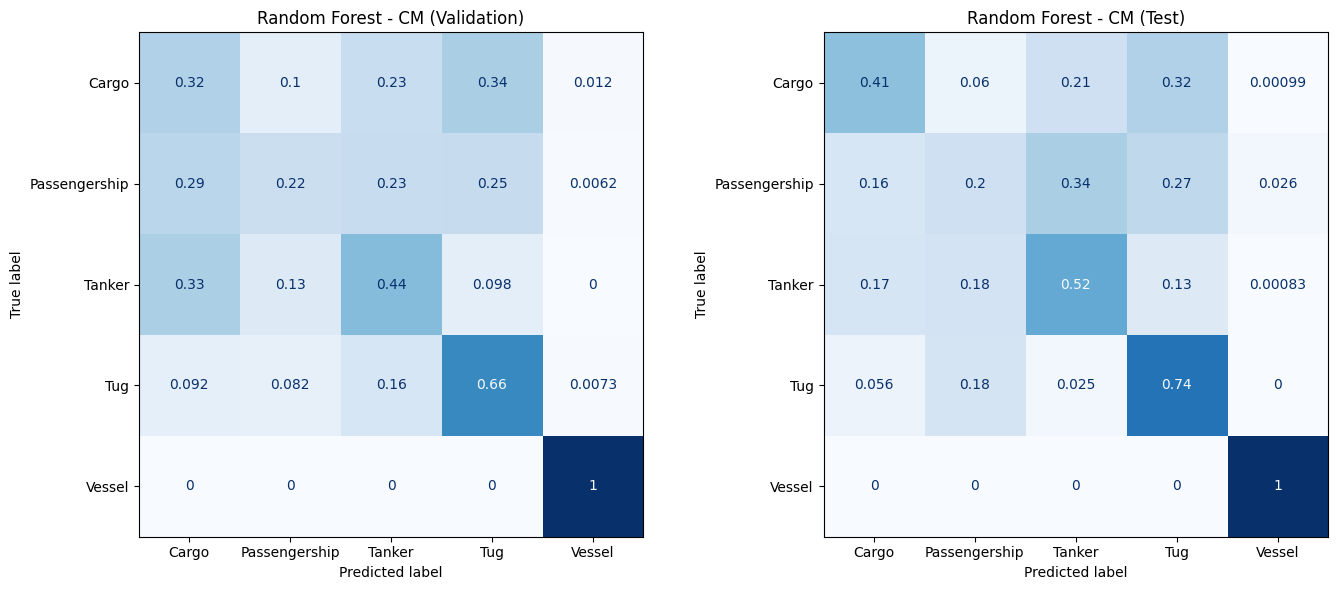

In [19]:
rf_plot_confusion_matrices(
    model=random_forest_model,
    X_val=X_val_imputed,
    y_val_encoded=y_val_encoded,
    X_test=X_test_imputed,
    y_test_encoded=y_test_encoded,
    subclass_encoder=subclass_encoder
)


### 1.2 SVM Model

In [20]:
svm_model = train_svm_multiclass(
    X_train_resampled, y_train_resampled,
    X_val_imputed, y_val_encoded,
    X_test_imputed, y_test_encoded
)


=== Report - Validation ===
              precision    recall  f1-score   support

           0     0.1052    0.1195    0.1119       862
           1     0.3161    0.0945    0.1455      1291
           2     0.5581    0.1168    0.1931      1276
           3     0.1925    0.5439    0.2843       956
           4     0.2609    1.0000    0.4138        18

    accuracy                         0.2071      4403
   macro avg     0.2865    0.3749    0.2297      4403
weighted avg     0.3178    0.2071    0.1840      4403

Accuratezza (Val) = 0.2071

=== Report - Test ===
              precision    recall  f1-score   support

           0     0.1614    0.1639    0.1626      1007
           1     0.2973    0.1095    0.1601      1607
           2     0.3664    0.1324    0.1945      1201
           3     0.1746    0.4673    0.2542       993
           4     0.0556    1.0000    0.1053         6

    accuracy                         0.2015      4814
   macro avg     0.2110    0.3746    0.1753      481

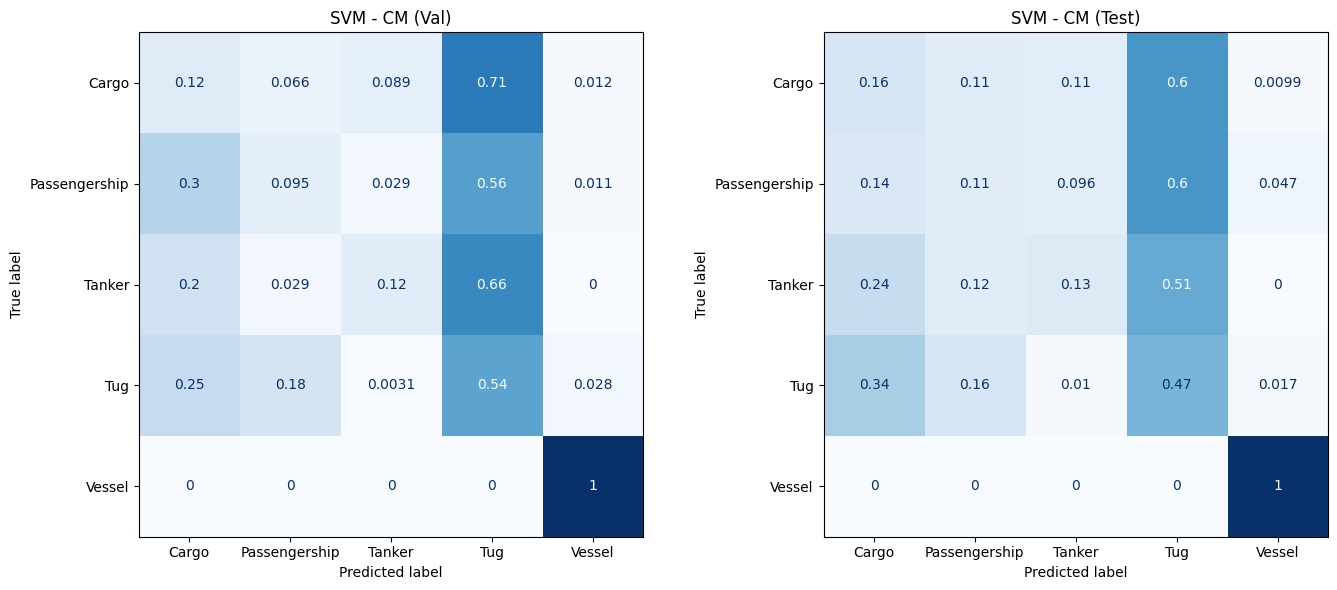

In [21]:
svm_plot_confusion_matrices(
    svm_model,
   X_val_imputed,
    y_val_encoded,
    X_test_imputed,
    y_test_encoded,
    subclass_encoder=subclass_encoder
)

### 1.3 LightGBM Model

In [22]:
lightgbm_model = train_lightgbm_multiclass(
    X_train_resampled, y_train_resampled,
    X_val_imputed, y_val_encoded,
    X_test_imputed, y_test_encoded
)

Accuratezza (Val) = 0.3995

=== Report - Validation ===
              precision    recall  f1-score   support

           0     0.2669    0.3434    0.3004       862
           1     0.4545    0.3710    0.4085      1291
           2     0.3966    0.4060    0.4012      1276
           3     0.4989    0.4686    0.4833       956
           4     0.5000    1.0000    0.6667        18

    accuracy                         0.3995      4403
   macro avg     0.4234    0.5178    0.4520      4403
weighted avg     0.4108    0.3995    0.4025      4403


Accuratezza (Test) = 0.4128

=== Report - Test ===
              precision    recall  f1-score   support

           0     0.3273    0.3962    0.3585      1007
           1     0.4449    0.3217    0.3734      1607
           2     0.4184    0.4080    0.4132      1201
           3     0.4630    0.5791    0.5145       993
           4     0.3000    1.0000    0.4615         6

    accuracy                         0.4128      4814
   macro avg     0.3907

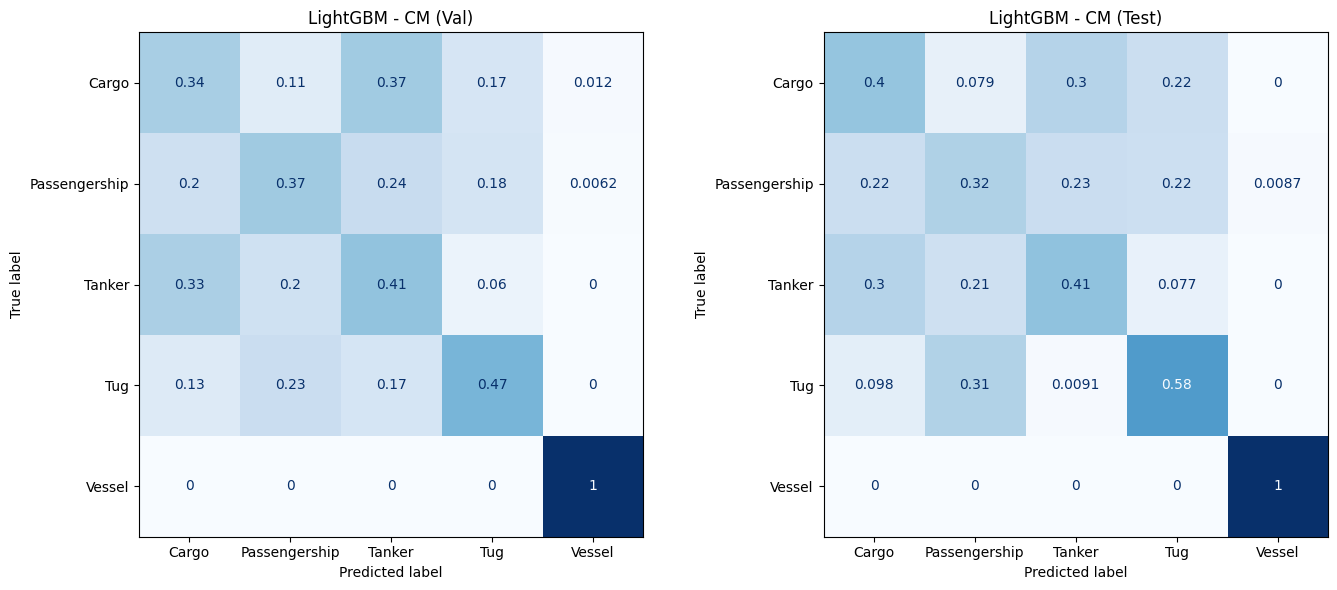

In [24]:
lightgbm_plot_confusion_matrices(
    lightgbm_model,
    X_val_imputed, y_val_encoded,
    X_test_imputed, y_test_encoded, subclass_encoder=subclass_encoder
)

## Esperimento 2

Esperimento effettuato prendendo come riferimento alcune features numeriche da “BirdNet”

In [25]:
csv_file_path_exp1 = 'C:/Users/frees/Documents/GitHub/UnderwaterClassification/features_extraction/exp1_audio_features.csv'
df_exp1 = pd.read_csv(csv_file_path_exp1)

In [26]:
df_exp1['File Name'] = df_exp1['File Name'].str[:-4]
df_exp1 = df_exp1[df_exp1['Class'] == 'Target'].copy()
# Aggiungi una colonna "Parent" che contiene il prefisso dei file per garantire la coesione dei segmenti
df_exp1['Parent'] = df_exp1['File Name'].str.extract(r'^(.*?)(?=_seg)')

# Filtra le subclass con almeno 10 parent distinti
parent_counts = df_exp1.groupby('Subclass')['Parent'].nunique()
subclasses_to_keep = parent_counts[parent_counts >= 10].index
df_exp1 = df_exp1[df_exp1['Subclass'].isin(subclasses_to_keep)].copy()

print(f"Dimensione totale dopo il filtraggio: {df_exp1.shape[0]} campioni")

Dimensione totale dopo il filtraggio: 43089 campioni


In [27]:
X_train_imputed_exp1, X_val_imputed_exp1, X_test_imputed_exp1, y_train_encoded_exp1, y_val_encoded_exp1, y_test_encoded_exp1, subclass_encoder_exp1 = split_dataset(df_exp1)


Train size: 33872 (78.61%)
Val size:   4403 (10.22%)
Test size:  4814 (11.17%)

Distribuzione di 'Subclass' nel train:
Subclass
Passengership    8830
Tanker           8744
Tug              8213
Cargo            7802
Vessel            283
Name: count, dtype: int64

Distribuzione di 'Subclass' nel val:
Subclass
Passengership    1291
Tanker           1276
Tug               956
Cargo             862
Vessel             18
Name: count, dtype: int64

Distribuzione di 'Subclass' nel test:
Subclass
Passengership    1607
Tanker           1201
Cargo            1007
Tug               993
Vessel              6
Name: count, dtype: int64


In [28]:
# Applica SMOTE
X_train_resampled_exp1, y_train_resampled_exp1 = apply_smote_multiclass(X_train_imputed_exp1, y_train_encoded_exp1, 1)


Class distribution after SMOTE:
1    8830
2    8830
0    8830
3    8830
4    8830
Name: count, dtype: int64


In [29]:
# Rimuovi le colonne non necessarie per evitare errori nei nomi delle feature
X_val_imputed_exp1 = X_val_imputed_exp1.drop(columns=["Class","File Name","Parent","Subclass"], errors='ignore')
X_test_imputed_exp1= X_test_imputed_exp1.drop(columns=["Class","File Name","Parent","Subclass"], errors='ignore')


### 2.1 Random Forest Model

In [30]:
random_forest_model_exp1 = train_random_forest_multiclass(
    X_train_resampled_exp1, y_train_resampled_exp1,
    X_val_imputed_exp1, y_val_encoded_exp1,
    X_test_imputed_exp1, y_test_encoded_exp1
)

Accuratezza (Val) = 0.4924
Log Loss (Val)    = 1.2121

=== Report - Validation ===
              precision    recall  f1-score   support

           0     0.3737    0.3794    0.3765       862
           1     0.5392    0.2982    0.3840      1291
           2     0.4761    0.6395    0.5458      1276
           3     0.5885    0.6506    0.6180       956
           4     0.4186    1.0000    0.5902        18

    accuracy                         0.4924      4403
   macro avg     0.4792    0.5935    0.5029      4403
weighted avg     0.4987    0.4924    0.4811      4403


Accuratezza (Test) = 0.4535
Log Loss (Test)    = 1.2194

=== Report - Test ===
              precision    recall  f1-score   support

           0     0.4479    0.2602    0.3291      1007
           1     0.4522    0.3709    0.4075      1607
           2     0.5172    0.5021    0.5095      1201
           3     0.4129    0.7210    0.5251       993
           4     0.5455    1.0000    0.7059         6

    accuracy          

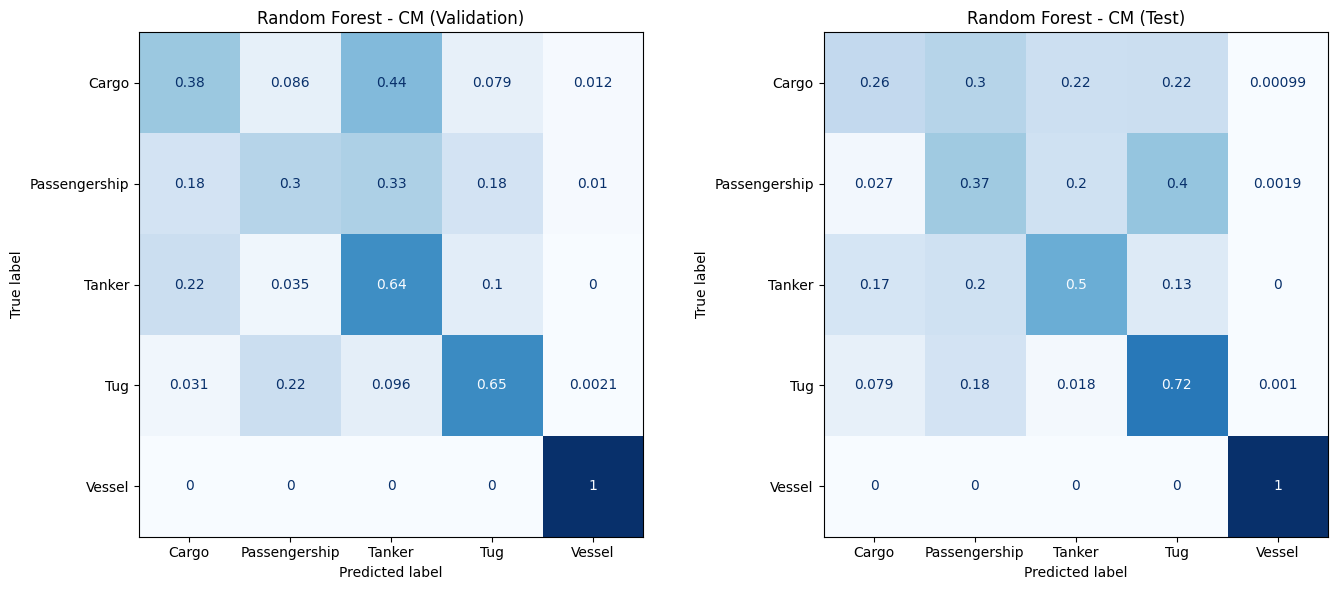

In [31]:
rf_plot_confusion_matrices(
    random_forest_model_exp1,
    X_val_imputed_exp1, y_val_encoded_exp1,
    X_test_imputed_exp1, y_test_encoded_exp1,subclass_encoder=subclass_encoder
)

### 2.2 SVM Model

In [32]:
svm_model_exp1 = train_svm_multiclass(
    X_train_resampled_exp1, y_train_resampled_exp1,
    X_val_imputed_exp1, y_val_encoded_exp1,
    X_test_imputed_exp1, y_test_encoded_exp1
)


=== Report - Validation ===
              precision    recall  f1-score   support

           0     0.1905    0.2135    0.2013       862
           1     0.3654    0.1472    0.2098      1291
           2     0.5336    0.4044    0.4601      1276
           3     0.3516    0.6977    0.4676       956
           4     0.1509    0.4444    0.2254        18

    accuracy                         0.3554      4403
   macro avg     0.3184    0.3814    0.3128      4403
weighted avg     0.3760    0.3554    0.3367      4403

Accuratezza (Val) = 0.3554

=== Report - Test ===
              precision    recall  f1-score   support

           0     0.2557    0.2552    0.2555      1007
           1     0.3212    0.1805    0.2311      1607
           2     0.4220    0.4255    0.4237      1201
           3     0.4438    0.7190    0.5488       993
           4     0.0698    1.0000    0.1304         6

    accuracy                         0.3693      4814
   macro avg     0.3025    0.5160    0.3179      481

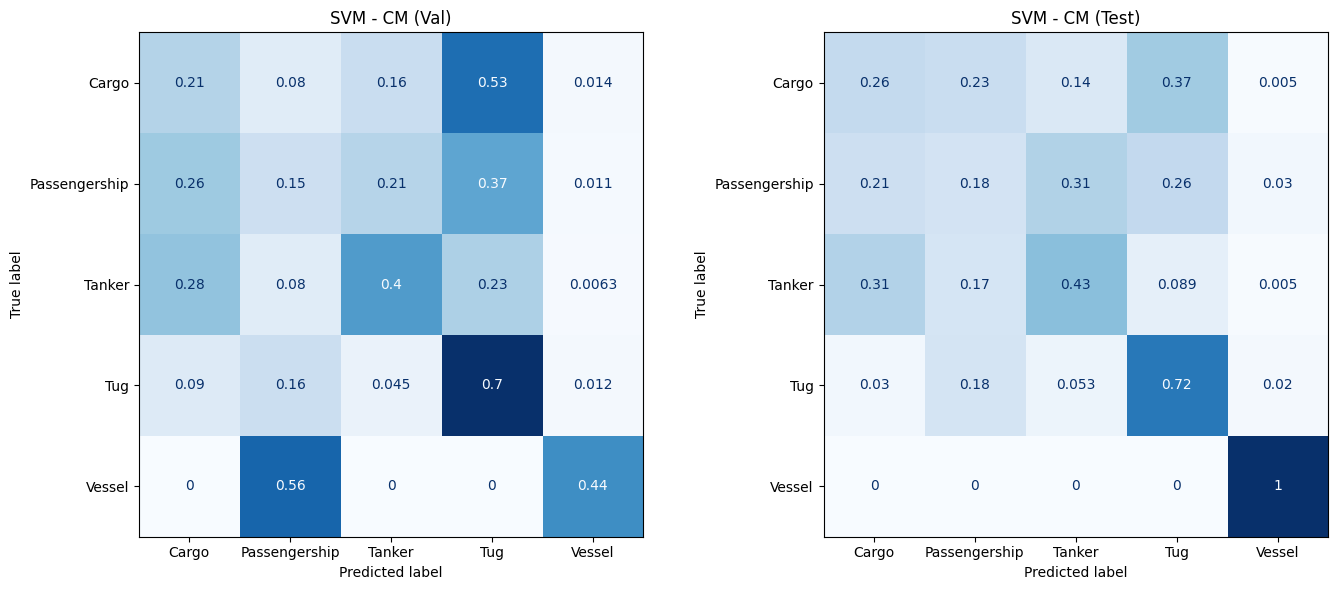

In [33]:
svm_plot_confusion_matrices(
    svm_model_exp1,
    X_val_imputed_exp1, y_val_encoded_exp1,
    X_test_imputed_exp1, y_test_encoded_exp1,subclass_encoder=subclass_encoder
)

### 2.3 LightGBM Model

In [34]:
lightgbm_model_exp1 = train_lightgbm_multiclass(
    X_train_resampled_exp1, y_train_resampled_exp1,
    X_val_imputed_exp1, y_val_encoded_exp1,
    X_test_imputed_exp1, y_test_encoded_exp1
)

Accuratezza (Val) = 0.5455

=== Report - Validation ===
              precision    recall  f1-score   support

           0     0.4344    0.5336    0.4789       862
           1     0.5938    0.4415    0.5064      1291
           2     0.5282    0.6089    0.5657      1276
           3     0.6836    0.6036    0.6411       956
           4     0.2609    1.0000    0.4138        18

    accuracy                         0.5455      4403
   macro avg     0.5002    0.6375    0.5212      4403
weighted avg     0.5617    0.5455    0.5471      4403


Accuratezza (Test) = 0.4913

=== Report - Test ===
              precision    recall  f1-score   support

           0     0.5089    0.4816    0.4949      1007
           1     0.5052    0.4231    0.4605      1607
           2     0.4543    0.4679    0.4610      1201
           3     0.5064    0.6365    0.5640       993
           4     0.2000    1.0000    0.3333         6

    accuracy                         0.4913      4814
   macro avg     0.4350

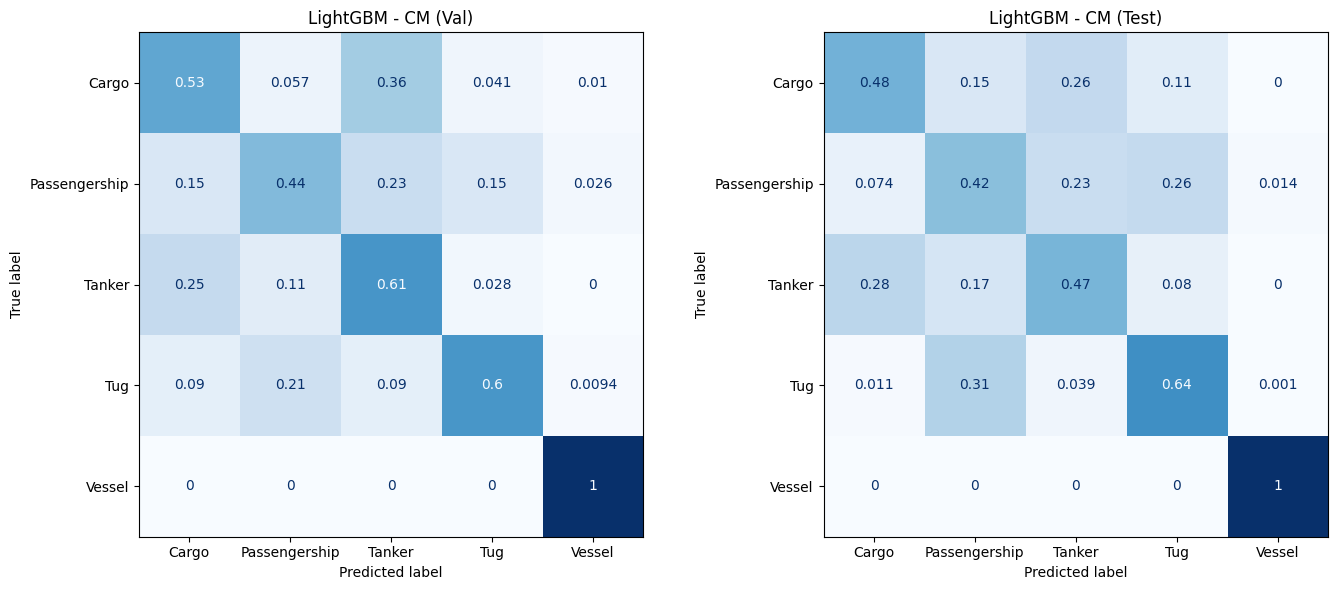

In [35]:
lightgbm_plot_confusion_matrices(
    lightgbm_model_exp1,
    X_val_imputed_exp1, y_val_encoded_exp1,
    X_test_imputed_exp1, y_test_encoded_exp1,subclass_encoder=subclass_encoder
)

## Esperimento 3

Esperimento effettuato prendendo come riferimento features numeriche da "A Survey on Audio Feature Extraction for Automatic Music Genre Classification" di Dhamodaran et al.

In [36]:
csv_file_path_exp2 = 'C:/Users/frees/Documents/GitHub/UnderwaterClassification/features_extraction/exp2_audio_features.csv'
df_exp2 = pd.read_csv(csv_file_path_exp2)
df_exp2 = df_exp2[df_exp2['Class'] == 'Target'].copy()

In [37]:
df_exp2['File Name'] = df_exp2['File Name'].str[:-4]
df_exp2 = df_exp2[df_exp2['Class'] == 'Target'].copy()
# Aggiungi una colonna "Parent" che contiene il prefisso dei file per garantire la coesione dei segmenti
df_exp2['Parent'] = df_exp2['File Name'].str.extract(r'^(.*?)(?=_seg)')

# Filtra le subclass con almeno 10 parent distinti
parent_counts = df_exp2.groupby('Subclass')['Parent'].nunique()
subclasses_to_keep = parent_counts[parent_counts >= 10].index
df_exp2 = df_exp2[df_exp2['Subclass'].isin(subclasses_to_keep)].copy()

print(f"Dimensione totale dopo il filtraggio: {df_exp2.shape[0]} campioni")

Dimensione totale dopo il filtraggio: 43089 campioni


In [38]:
X_train_imputed_exp2, X_val_imputed_exp2, X_test_imputed_exp2, y_train_encoded_exp2, y_val_encoded_exp2, y_test_encoded_exp2, subclass_encoder_exp2 = split_dataset(df_exp2)
X_train_resampled_exp2, y_train_resampled_exp2 = apply_smote_multiclass(X_train_imputed_exp2, y_train_encoded_exp2, 1)


# Rimuovi le colonne non necessarie per evitare errori nei nomi delle feature
X_val_imputed_exp2 = X_val_imputed_exp2.drop(columns=["Class","File Name","Parent","Subclass"], errors='ignore')
X_test_imputed_exp2= X_test_imputed_exp2.drop(columns=["Class","File Name","Parent","Subclass"], errors='ignore')


Train size: 33872 (78.61%)
Val size:   4403 (10.22%)
Test size:  4814 (11.17%)

Distribuzione di 'Subclass' nel train:
Subclass
Passengership    8830
Tanker           8744
Tug              8213
Cargo            7802
Vessel            283
Name: count, dtype: int64

Distribuzione di 'Subclass' nel val:
Subclass
Passengership    1291
Tanker           1276
Tug               956
Cargo             862
Vessel             18
Name: count, dtype: int64

Distribuzione di 'Subclass' nel test:
Subclass
Passengership    1607
Tanker           1201
Cargo            1007
Tug               993
Vessel              6
Name: count, dtype: int64

Class distribution after SMOTE:
1    8830
2    8830
0    8830
3    8830
4    8830
Name: count, dtype: int64


### 3.1 Random Forest Model

In [39]:
random_forest_model_exp2 = train_random_forest_multiclass(
    X_train_resampled_exp2, y_train_resampled_exp2,
    X_val_imputed_exp2, y_val_encoded_exp2,
    X_test_imputed_exp2, y_test_encoded_exp2
)

Accuratezza (Val) = 0.4956
Log Loss (Val)    = 1.1765

=== Report - Validation ===
              precision    recall  f1-score   support

           0     0.3333    0.3643    0.3481       862
           1     0.5341    0.2789    0.3664      1291
           2     0.4908    0.6285    0.5512      1276
           3     0.6255    0.7197    0.6693       956
           4     0.3396    1.0000    0.5070        18

    accuracy                         0.4956      4403
   macro avg     0.4647    0.5983    0.4884      4403
weighted avg     0.5013    0.4956    0.4827      4403


Accuratezza (Test) = 0.4595
Log Loss (Test)    = 1.1620

=== Report - Test ===
              precision    recall  f1-score   support

           0     0.4361    0.3118    0.3636      1007
           1     0.4125    0.2744    0.3296      1607
           2     0.5016    0.5254    0.5132      1201
           3     0.4670    0.8258    0.5966       993
           4     0.5455    1.0000    0.7059         6

    accuracy          

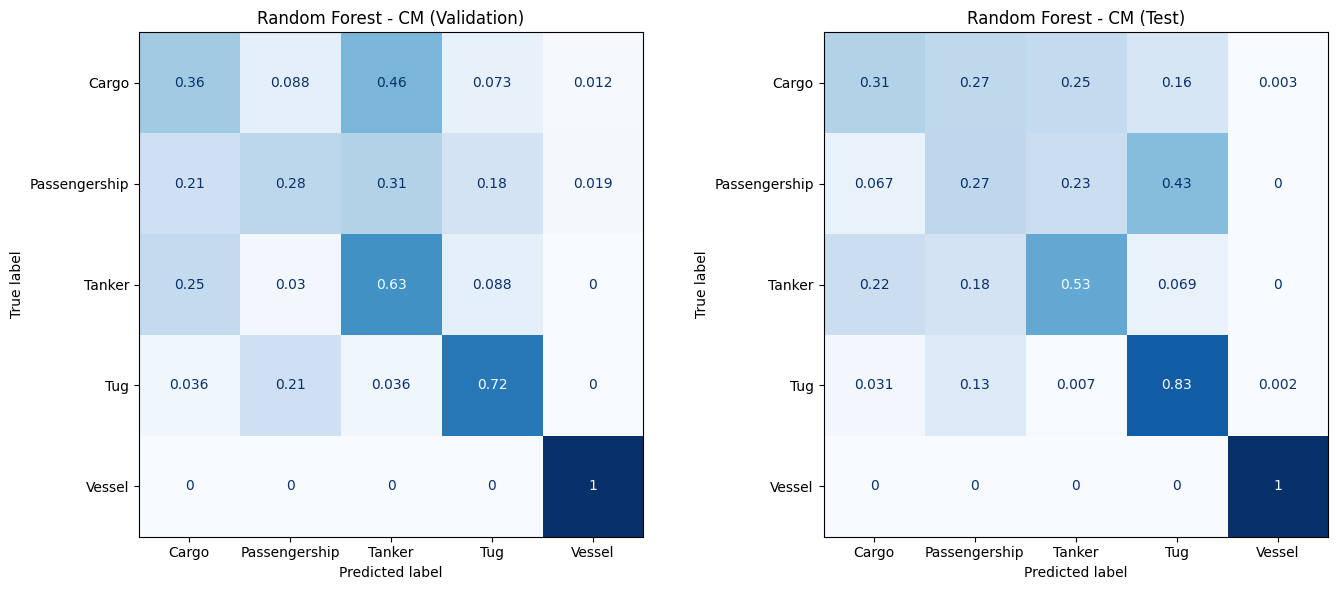

In [40]:
rf_plot_confusion_matrices(
    random_forest_model_exp2,
    X_val_imputed_exp2, y_val_encoded_exp2,
    X_test_imputed_exp2, y_test_encoded_exp2,subclass_encoder=subclass_encoder
)

### 3.2 SVM Model

In [41]:
svm_model_exp2 = train_svm_multiclass(
    X_train_resampled_exp2, y_train_resampled_exp2,
    X_val_imputed_exp2, y_val_encoded_exp2,
    X_test_imputed_exp2, y_test_encoded_exp2
)


=== Report - Validation ===
              precision    recall  f1-score   support

           0     0.4275    0.5882    0.4951       862
           1     0.5717    0.2254    0.3233      1291
           2     0.5941    0.6458    0.6189      1276
           3     0.5869    0.7877    0.6726       956
           4     0.4737    1.0000    0.6429        18

    accuracy                         0.5435      4403
   macro avg     0.5308    0.6494    0.5506      4403
weighted avg     0.5529    0.5435    0.5198      4403

Accuratezza (Val) = 0.5435

=== Report - Test ===
              precision    recall  f1-score   support

           0     0.4690    0.3833    0.4219      1007
           1     0.4876    0.3665    0.4185      1607
           2     0.5294    0.5404    0.5348      1201
           3     0.4688    0.7271    0.5701       993
           4     0.3529    1.0000    0.5217         6

    accuracy                         0.4886      4814
   macro avg     0.4615    0.6035    0.4934      481

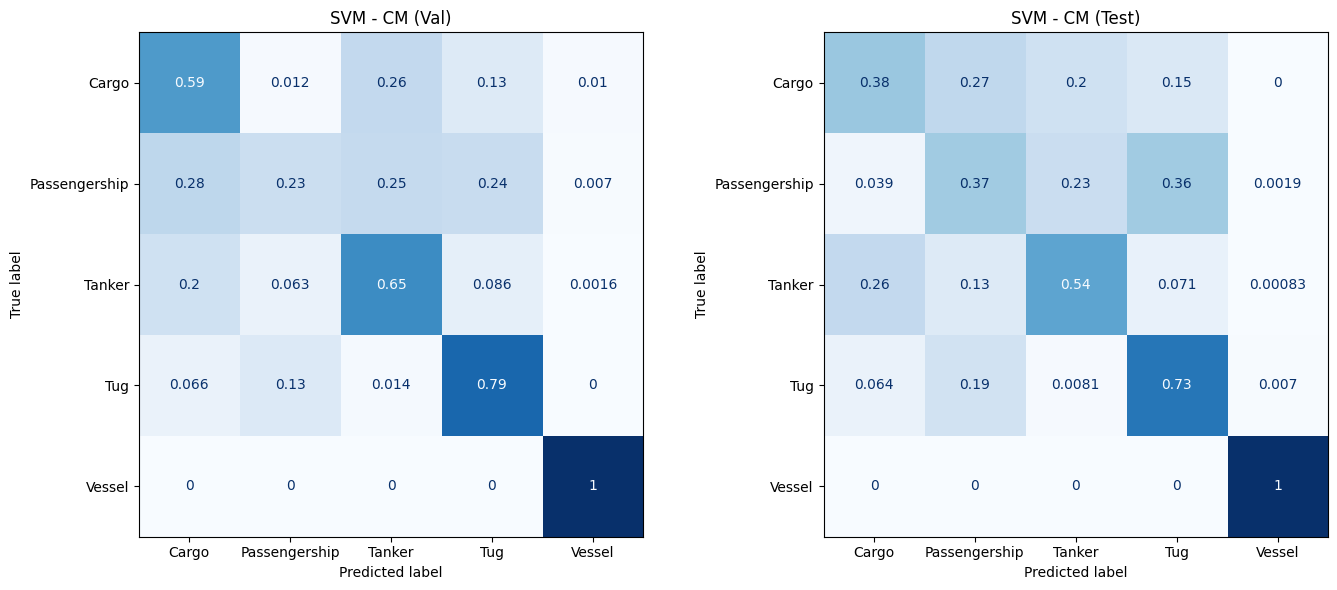

In [43]:
svm_plot_confusion_matrices(
    svm_model_exp2,
    X_val_imputed_exp2, y_val_encoded_exp2,
    X_test_imputed_exp2, y_test_encoded_exp2,subclass_encoder=subclass_encoder
)

### 3.3 LightGBM Model

In [44]:
lightgbm_model_exp2 = train_lightgbm_multiclass(
    X_train_resampled_exp2, y_train_resampled_exp2,
    X_val_imputed_exp2, y_val_encoded_exp2,
    X_test_imputed_exp2, y_test_encoded_exp2
)

Accuratezza (Val) = 0.5455

=== Report - Validation ===
              precision    recall  f1-score   support

           0     0.4363    0.5603    0.4906       862
           1     0.5587    0.4609    0.5051      1291
           2     0.5477    0.6027    0.5739      1276
           3     0.6867    0.5617    0.6180       956
           4     0.4000    1.0000    0.5714        18

    accuracy                         0.5455      4403
   macro avg     0.5259    0.6371    0.5518      4403
weighted avg     0.5587    0.5455    0.5470      4403


Accuratezza (Test) = 0.5098

=== Report - Test ===
              precision    recall  f1-score   support

           0     0.5316    0.5432    0.5373      1007
           1     0.4842    0.4194    0.4495      1607
           2     0.5280    0.5187    0.5233      1201
           3     0.5106    0.6083    0.5551       993
           4     0.2000    1.0000    0.3333         6

    accuracy                         0.5098      4814
   macro avg     0.4509

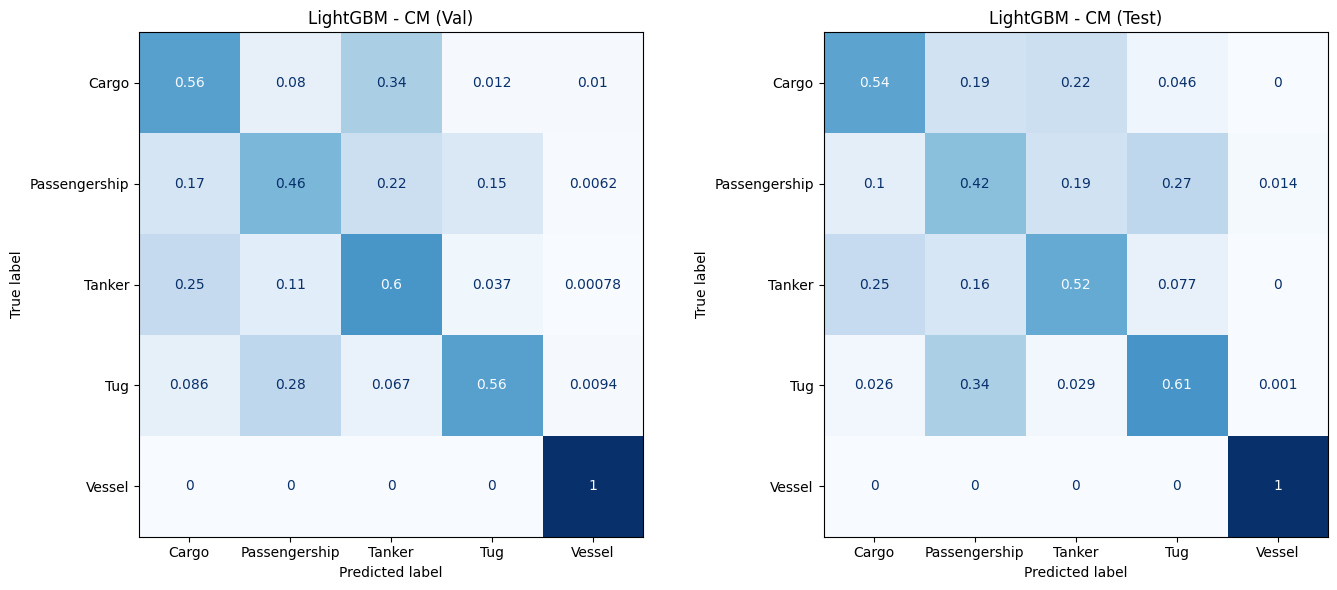

In [45]:
lightgbm_plot_confusion_matrices(
    lightgbm_model_exp2,
    X_val_imputed_exp2, y_val_encoded_exp2,
    X_test_imputed_exp2, y_test_encoded_exp2,subclass_encoder=subclass_encoder
)

TEST CON MODELLI CON COMPLESSITà PIù ALTA

RANDOM FORSET

In [46]:
from oversampling_training import oversampling_multiclass_extra

In [49]:

random_forest_model_exp2 = train_random_forest_multiclass_extra(
    X_train_resampled_exp2, y_train_resampled_exp2,
    X_val_imputed_exp2, y_val_encoded_exp2,
    X_test_imputed_exp2, y_test_encoded_exp2
)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Accuratezza (Val) = 0.5408
Log Loss (Val)    = 1.1000

=== Report - Validation ===
              precision    recall  f1-score   support

           0     0.4042    0.4896    0.4428       862
           1     0.5402    0.4477    0.4896      1291
           2     0.5444    0.6442    0.5901      1276
           3     0.7272    0.5659    0.6365       956
           4     0.5143    1.0000    0.6792        18

    accuracy                         0.5408      4403
   macro avg     0.5460    0.6295    0.5676      4403
weighted avg     0.5553    0.5408    0.5422      4403


Accuratezza (Test) = 0.5299
Log Loss (Test)    = 1.0376

=== Report - Test ===
              precision    recall  f1-score   support

           0     0.5390    0.4667    0.5003      1007
           1     0.5032    0.4835    0.4932      1607
           2     0.5565    0.5704    0.5633      1201
           3     0.5280    0.6173    0.5692       993
           4 

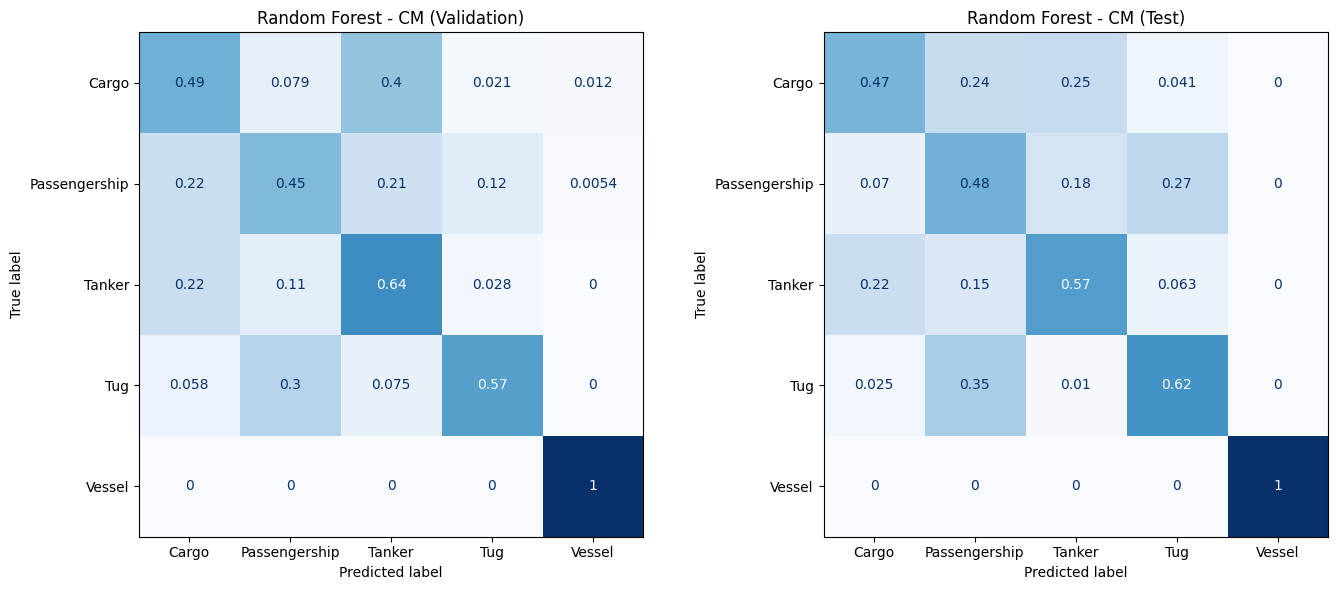

In [50]:
rf_plot_confusion_matrices(
    random_forest_model_exp2,
    X_val_imputed_exp2, y_val_encoded_exp2,
    X_test_imputed_exp2, y_test_encoded_exp2,subclass_encoder=subclass_encoder
)